## Understanding DCLP3 Dataset
This notebook tries provides details on the structure of the DCLP3 dataset and makes suggestions how to process the data.

## The DCLP3 study

**Title**: The International Diabetes Closed Loop (iDCL) trial: Clinical Acceptance of 
the Artificial Pancreas - A Pivotal Study of t:slim X2 with Control-IQ Technology (DCLP3)

**Description**: The objective of the study is to assess efficacy and safety of a 
closed loop system (t:slim X2 with Control-IQ Technology) in a large randomized controlled trial.
    
**Devices**: t:slim X2 with Control-IQ and Dexcom G6 system

**Study Population**: Teens and adults aged 14 years or older


# Data
The study data folder is named **DCLP3 Public Dataset - Release 3 - 2022-08-04**
From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

* **Pump_BolusDelivered.txt**: List of pupm data downloaded (bolus data only)
* **Pump_BasalRateChange.txt**: List of pump data dowloaded (basal data only)
* **Pump_CGMGlucoseValue.txt**: List of cgm data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Tandem pump events and the Dexcom cgm. The glossary provides information about each column. Each file contains a limited amount of columns compared to the FLAIR data. Below are **all** of the columns contained in each file

## Pump_BolusDelivered

| Column| Description  | Comment |
|--|--|--|
| PtID               | Patient ID||
| DataDtTm           | Local time of event||
| BolusAmount        | Size of bolus **delivered** |Units|
| DataDtTm_adjusted  | Local time of event -- Including adjustments made at Jaeb |*1|
| BolusType          | The bolus insulin delivery type "Standard or Extended" |*2|

## Pump_BasalRateChange

| Column| Description | Comment |
|--------------------|-----|-------|
| PtID               | Patient ID|       |
| DataDtTm           | Date-time of basal rate change|       |
| CommandedBasalRate | The new basal rate| range: 0-25, unit = U/h, Glossary names this variable BasalRate|
| DataDtTm_adjusted  | Local time of event -- Including adjustments made at Jaeb|*1|
|RecID| Unique record ID in table | this data set comes from two tables, so there will be duplicate values in this column|

## Pump_CGMGlucoseValue
| Column             | Description| Comment |
|--------------------|--|--|
| PtID               | Patient ID |       |
| DataDtTm           | Date-time of event ||
| CGMValue           | CGM value in mg/dl| *3|
| DataDtTm_adjusted  | Local time of event -- **Including adjustments made at Jaeb** |*1|

\* 1: Glossary does not explain this further, unclear which time should be used. Needs to be investigated.

\* 2: There is no information about when the extended duration or if the time refers to completion or start, needs to be checked.

\* 3: Glossary mentions *"40-400 are legitimate glucose values. 0 is used when the reading is high or low. Use of this field depends on the glucoseValueStatus field."* but there is no `glucoseValueStatus` field.



## Observations
* We need to figure out how to deal with DataDtTm_adjusted
* We need to make asusmptions about extended bolus durations 
* We should analyze if an extended boluses are reported upcon delivery or completion
* We need to be aware that there will be duplicates in Record ids
* 0 CGMs need to be handled (checking previous, value >0 to decide if <40, >400) 

**Differences to PEDAP:** PEDAP and DCLP are conducated on Tandem and therefore have similar data structures. 
But some differences exist:
 - Basal rate column in PEDAP is named `BasalRate`, in DCLP3 it is `CommandedBasalRate`
 - DCLP we have two date columns `DataDtTm` and `DataDtTm_adjusted`, in PEDAP there are no adjusted datetimes
 - In `PEDAP`, extended boluses come with duration and are reported at completion. `DCLP`, we only know if a bolus is extended, but miss the duration or if the extended portion is reported at the announcement or at the completion. 
 - `DCLP` Bolus table does not come with `CarbAmount` column

## Load the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
sys.path.append(os.path.join(os.getcwd(), '..'))
from src import date_helper
from datetime import datetime, timedelta

In [2]:
# load the raw data
 
import time
start_time = time.time()
study_path = os.path.join(os.getcwd(), '../data/raw/DCLP3 Public Dataset - Release 3 - 2022-08-04/')
df_bolus = pd.read_csv(os.path.join(study_path,'Data Files', 'Pump_BolusDelivered.txt'), sep='|', low_memory=False)
                       #usecols=['RecID', 'PtID', 'DataDtTm', 'BolusAmount', 'BolusType', 'DataDtTm_adjusted'])

df_basal = pd.read_csv(os.path.join(study_path, 'Data Files', 'Pump_BasalRateChange.txt'), sep='|', low_memory=False)
#                       usecols=['RecID', 'PtID', 'DataDtTm', 'CommandedBasalRate', 'DataDtTm_adjusted'])

df_cgm = pd.read_csv(os.path.join(study_path, 'Data Files', 'Pump_CGMGlucoseValue.txt'), sep='|', low_memory=False)
#usecols=['RecID', 'PtID', 'DataDtTm', 'CGMValue', 'DataDtTm_adjusted'])

end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

display(df_bolus.head(1))
display(df_basal.head(1))
display(df_cgm.head(1))

df_bolus.Name = 'Bolus'
df_basal.Name = 'Basal'
df_cgm.Name = 'CGM'

Execution time: 6.07 seconds


,PtID,RecID,DataDtTm,BolusAmount,DataDtTm_adjusted,BolusType
0,79,10100,2018-04-29 04:45:44,0.645283,NaN,Standard


,PtID,RecID,DataDtTm,CommandedBasalRate,DataDtTm_adjusted
0,10,3,2018-04-04 12:52:41,2.0,NaN


,PtID,RecID,DataDtTm,CGMValue,HighLowIndicator,DataDtTm_adjusted
0,22,1,2018-05-30 16:44:14,83,0,NaN


### Duplicates & Missing Data
We see that there are many duplicated data points without additional information. Also, we see that some DateTime data is missing for the boluses. We also see that for manyu patients there is no basal data. For all these cases, we remove the data.

In [3]:
#check for null values
display(df_cgm.agg('isna').sum())
display(df_bolus.agg('isna').sum())
display(df_basal.agg('isna').sum())

PtID                       0
RecID                      0
DataDtTm                   0
CGMValue                   0
HighLowIndicator           0
DataDtTm_adjusted    5592114
dtype: int64

PtID                      0
RecID                     0
DataDtTm                  0
BolusAmount               0
DataDtTm_adjusted    218185
BolusType                 0
dtype: int64

PtID                        0
RecID                       0
DataDtTm                    0
CommandedBasalRate          0
DataDtTm_adjusted     2572390
dtype: int64

In [4]:
#check for row duplicates
for dataset in [df_bolus, df_basal, df_cgm]:
    print(f"Duplicated rows in {dataset.Name}: {dataset.duplicated().sum()}")

print(f"Basal Duplicates (PtID, RecID): {df_basal.duplicated(subset=['PtID', 'RecID'], keep=False).sum()}")
print(f"Basal Duplicates (PtID, DataDtTm): {df_basal.duplicated(subset=['PtID', 'DataDtTm'], keep=False).sum()}")
print(f"Basal Duplicates (PtID, DataDtTm, CommandedBasalRate): {df_basal.duplicated(subset=['PtID', 'DataDtTm', 'CommandedBasalRate'], keep=False).sum()}")

print(f"CGM Duplicates (PtID, RecID): {df_cgm.duplicated(subset=['PtID', 'RecID'], keep=False).sum()}")
print(f"CGM Duplicates (PtID, DataDtTm): {df_cgm.duplicated(subset=['PtID', 'DataDtTm'], keep=False).sum()}")
print(f"CGM Duplicates (PtID, DataDtTm, CGMValue): {df_cgm.duplicated(subset=['PtID', 'DataDtTm', 'CGMValue'], keep=False).sum()}")

print(f"Bolus Duplicates (PtID, RecID): {df_bolus.duplicated(subset=['PtID', 'RecID'], keep=False).sum()}")
print(f"Bolus Duplicates (PtID, DataDtTm): {df_bolus.duplicated(subset=['PtID', 'DataDtTm'], keep=False).sum()}")
print(f"Bolus Duplicates (PtID, DataDtTm, BolusType): {df_bolus.duplicated(subset=['PtID', 'DataDtTm', 'BolusType'], keep=False).sum()}")


Duplicated rows in Bolus: 0
Duplicated rows in Basal: 0
Duplicated rows in CGM: 0
Basal Duplicates (PtID, RecID): 0
Basal Duplicates (PtID, DataDtTm): 22
Basal Duplicates (PtID, DataDtTm, CommandedBasalRate): 0
CGM Duplicates (PtID, RecID): 0
CGM Duplicates (PtID, DataDtTm): 7110
CGM Duplicates (PtID, DataDtTm, CGMValue): 7014
Bolus Duplicates (PtID, RecID): 80
Bolus Duplicates (PtID, DataDtTm): 94
Bolus Duplicates (PtID, DataDtTm, BolusType): 0


We see that 
* There are only 22 basal Duplicates and these have diffferent basal rates
* There are only 94 bolus duplicates and these all have different Bolus Types (Standard vs. Extended)
* most cgm duplicates share the same value

Let's quickly check how CGM duplicates are correlated.

0.063% of the CGM data is duplicated


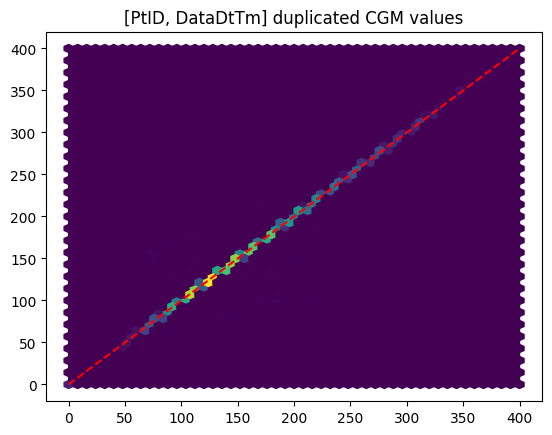

In [5]:
#show correlation between duplicated CGM values
print(f"{(df_cgm.duplicated(['PtID', 'DataDtTm']).sum()/len(df_cgm))*100:.3f}% of the CGM data is duplicated")
df_cgm.sort_values(['PtID', 'DataDtTm','RecID'], inplace=True)
duplicates = df_cgm.loc[df_cgm.duplicated(['PtID', 'DataDtTm'], keep=False)]

grps = duplicates.groupby(['PtID', 'DataDtTm'])
first_rows = grps.first().reset_index()
second_rows = grps.last().reset_index()
plt.hexbin(first_rows.CGMValue, second_rows.CGMValue, gridsize=50, cmap='viridis')
plt.plot([0, 400], [0, 400], color='red', linestyle='--')
plt.title('[PtID, DataDtTm] duplicated CGM values');

In conclusion:
* As the data glossary mentions, record duplicates are expected and should be ignored (data comes from multiple sources)
* the number of duplicates is almost negligible (only CGM is of interest)
* On inspection we see that CGM duplicates are almost equal

We deal with duplicates as follows:
* Basal: Taking the maximum value (we see some zero values)
* CGM: Taking the first value
* Bolus, we handle later in the Extended Bolus section

In [6]:
#drop duplicates either taking max or first value
from src import pandas_helper

#_, _, drop_indexes = pandas_helper.get_duplicated_max_indexes(df_bolus, ['PtID', 'DataDtTm'], 'BolusAmount')
#df_bolus.drop(drop_indexes, inplace=True)

df_cgm.drop_duplicates(['PtID', 'DataDtTm'], keep='first', inplace=True)

_, _, drop_indexes = pandas_helper.get_duplicated_max_indexes(df_basal, ['PtID', 'DataDtTm'], 'CommandedBasalRate')
df_basal.drop(drop_indexes, inplace=True)

### Keep only patients with complete data

In [7]:
from functools import reduce

print(f"Unique patients: Basal: {len(df_basal.PtID.unique())}, Bolus: {len(df_bolus.PtID.unique())}, CGM: {len(df_cgm.PtID.unique())}")

#reduce to those with data in all datasets
total_ids = reduce(np.intersect1d, (df_basal.PtID.unique(), df_bolus.PtID.unique(), df_cgm.PtID.unique()))
print('Total PtIDs with all forms of data: ', len(total_ids))

#filter out those without data in all datasets
df_basal = df_basal[df_basal.PtID.isin(total_ids)]
df_bolus = df_bolus[df_bolus.PtID.isin(total_ids)]
df_cgm = df_cgm[df_cgm.PtID.isin(total_ids)]

Unique patients: Basal: 125, Bolus: 125, CGM: 112
Total PtIDs with all forms of data:  112


### DateTime Strings
In Flair and PEDAP datetime strings were reported in inconsistent time formats: time components were missing at midnights which required special handling.

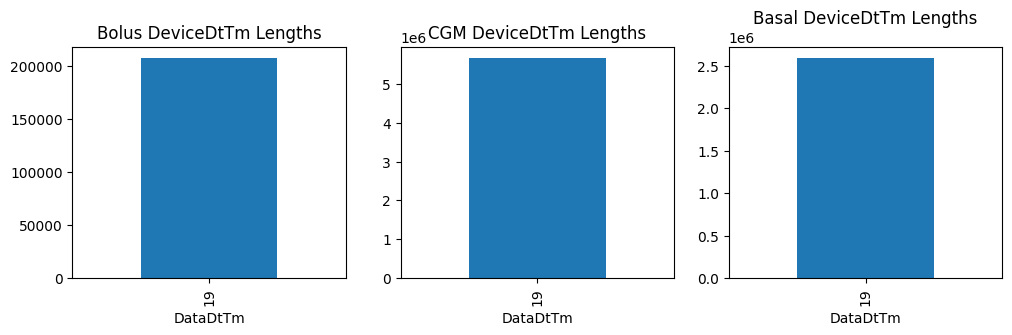

Example for 19 characters in Bolus: 2018-04-29 04:45:44
Example for 19 characters in CGM: 2018-01-10 05:18:32
Example for 19 characters in Basal: 2018-04-04 12:52:41
Missing datetime values in bolus: 0
Missing datetime values in basal: 0
Missing datetime values in cgm: 0


In [8]:
#check datetime string lengths
datetime_column = 'DataDtTm'
df_bolus.Name = 'Bolus'
df_basal.Name = 'Basal'
df_cgm.Name = 'CGM'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
df_bolus[datetime_column].str.len().value_counts().plot.bar(ax=axes[0], title='Bolus DeviceDtTm Lengths')
df_cgm[datetime_column].str.len().value_counts().plot.bar(ax=axes[1], title='CGM DeviceDtTm Lengths')
df_basal[datetime_column].str.len().value_counts().plot.bar(ax=axes[2], title='Basal DeviceDtTm Lengths')
plt.show()

#print examples of the different string lengths (if exists)
for dataset in [df_bolus, df_cgm, df_basal]:
    value_counts = dataset[datetime_column].str.len().value_counts()
    for length, count in value_counts.items():
        print(f"Example for {length} characters in {dataset.Name}: {dataset[datetime_column][dataset[datetime_column].str.len() == length].iloc[0]}")



#check if there are missing datetime values
print(f"Missing datetime values in bolus: {df_bolus['DataDtTm'].isnull().sum()}")
print(f"Missing datetime values in basal: {df_basal['DataDtTm'].isnull().sum()}")
print(f"Missing datetime values in cgm: {df_cgm['DataDtTm'].isnull().sum()}")

As we can see
 - all datetime strings are consistent (19 charcters) indicating leading zeros. 
 - there are no missing datetimes.

We can therefore move forward using the pd.to_datetime without

In [9]:
#convert the datetime strings to datetime objects
df_bolus['DataDtTm'] = pd.to_datetime(df_bolus['DataDtTm'], errors='coerce')
df_basal['DataDtTm'] = pd.to_datetime(df_basal['DataDtTm'], errors='coerce')
df_cgm['DataDtTm'] = pd.to_datetime(df_cgm['DataDtTm'], errors='coerce')

df_cgm['DataDtTm_adjusted'] = pd.to_datetime(df_cgm['DataDtTm_adjusted'], errors='coerce')
df_basal['DataDtTm_adjusted'] = pd.to_datetime(df_basal['DataDtTm_adjusted'], errors='coerce')
df_bolus['DataDtTm_adjusted'] = pd.to_datetime(df_bolus['DataDtTm_adjusted'], errors='coerce')


### Adjusted Datetimes

We know there are datetime adjusted events, let's investigate:

In [10]:
#check for adjusted datetime durations
bolus_adjusted_percentage = df_bolus['DataDtTm_adjusted'].notna().mean() * 100
basal_adjusted_percentage = df_basal['DataDtTm_adjusted'].notna().mean() * 100
cgm_adjusted_percentage = df_cgm['DataDtTm_adjusted'].notna().mean() * 100

print(f"Adjusted boluses: {bolus_adjusted_percentage:.2f}%")
print(f"Adjusted basals: {basal_adjusted_percentage:.2f}%")
print(f"Adjusted cgms: {cgm_adjusted_percentage:.2f}%")

#describe the adjustment duration
display((df_cgm.DataDtTm_adjusted-df_cgm.DataDtTm).describe())

Adjusted boluses: 1.48%
Adjusted basals: 1.48%
Adjusted cgms: 1.50%


count                          85188
mean     128 days 18:54:26.383833408
std      603 days 21:15:47.591760424
min                -1 days +00:00:00
25%                -1 days +00:00:00
50%                -1 days +00:00:00
75%                -1 days +18:00:00
max               3904 days 09:56:00
dtype: object

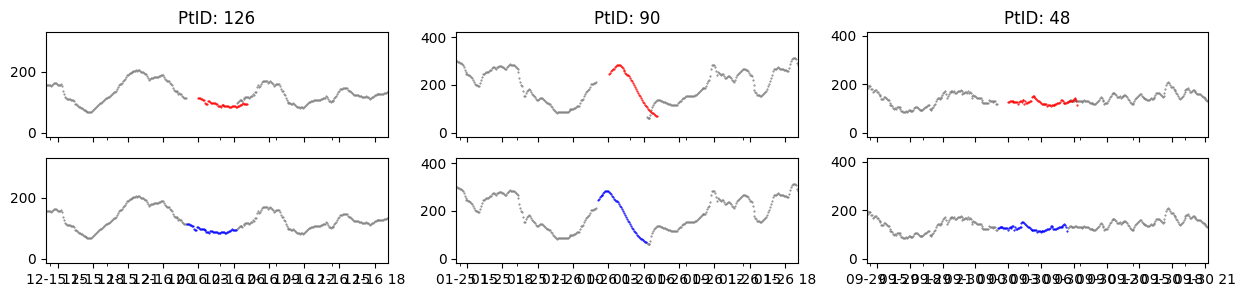

In [11]:
# plot cgm data using the adjusted vs. unadjusted datetime values

def split_groups(x: pd.Series, threshold) -> pd.Series:
   """Assigns unique group IDs based on the distance between consecutive values.

   Args:
       x (pd.Series): Series of numerical values.
       threshold : The maximum duration between two consecutive values to consider them in the same group.

   Returns:
       (pd.Series): The Series containing the data.
   """
   
   return (x.diff()>threshold).cumsum()

# Example usage for the first three patients
datetime_col = 'DataDtTm'
adjusted_datetime_col = 'DataDtTm_adjusted'
cgm_col = 'CGMValue'

#get patient ids
patients_with_adj_datetimes = df_cgm.loc[df_cgm[adjusted_datetime_col].notnull()]['PtID'].unique()

#Plot the cgm data for the three patients
f,AX = plt.subplots(2,3,figsize=(15,3),sharex='col')
#([54,128,19])
for i_patient,patient_id in enumerate(np.random.choice(patients_with_adj_datetimes,3)):
    temp = df_cgm.loc[df_cgm.PtID == patient_id]
    temp.loc[temp.DataDtTm_adjusted.isnull()].plot.scatter(x='DataDtTm', y='CGMValue',s=1, marker='.',ax=AX[0,i_patient],color='gray')
    temp.loc[temp.DataDtTm_adjusted.isnull()].plot.scatter(x='DataDtTm', y='CGMValue',s=1, marker='.',ax=AX[1,i_patient],color='gray')

    temp.loc[temp.DataDtTm_adjusted.notnull()].plot.scatter(x='DataDtTm', y='CGMValue',s=1, marker='.',ax=AX[0,i_patient],color='red')
    temp.loc[temp.DataDtTm_adjusted.notnull()].plot.scatter(x='DataDtTm_adjusted', y='CGMValue',s=1, marker='.',ax=AX[1,i_patient],color='blue')

    #limit the x-axis to the first group of adjusted datetime values
    group_labels = split_groups(temp[adjusted_datetime_col].dropna(), timedelta(days=1))
    first_group = temp.groupby(group_labels).get_group(0)
    
    start,end = first_group[datetime_col].agg(['min','max'])
    start2,end2 = first_group[adjusted_datetime_col].agg(['min','max'])
    
    start,end = min(start,start2),max(end,end2)

    AX[0][i_patient].set_xlim([start-timedelta(hours=12),end+timedelta(hours=12)])
    AX[0][i_patient].set_title("PtID: "+str(patient_id)); 
    AX[1][i_patient].set_xlabel(''); 
    AX[0][i_patient].set_ylabel('')
    AX[1][i_patient].set_ylabel('')

In [12]:
#compare the time difference between consecutive values before and after the adjustment
df_cgm['DataDtTmNew'] = df_cgm['DataDtTm_adjusted'].fillna(df_cgm['DataDtTm'])
before = df_cgm.sort_values('DataDtTm').dropna(subset=['DataDtTm']).groupby('PtID').DataDtTm.agg('diff').describe()
after = df_cgm.sort_values('DataDtTmNew').dropna(subset=['DataDtTmNew']).groupby('PtID').DataDtTmNew.agg('diff').describe()
pd.DataFrame({'Before': before, 'After': after})

,Before,After
count,5673765,5673765
mean,0 days 00:06:57.032272045,0 days 00:05:13.013477822
std,2 days 00:51:46.912755045,0 days 00:46:14.062200580
min,0 days 00:00:01,0 days 00:00:00
25%,0 days 00:04:59,0 days 00:04:59
50%,0 days 00:05:00,0 days 00:05:00
75%,0 days 00:05:01,0 days 00:05:01
max,3869 days 12:22:09,69 days 07:13:39


**Conclusion**: As we can see, using the adjusted datetimes moves the cgm data in the right spot (mostly) and reduces the variation in time differences. 

In [13]:
# assign the adjusted datetime values to the datetime column, drop other columns
df_cgm = df_cgm.drop(columns=['DataDtTm','DataDtTm_adjusted']).rename(columns={'DataDtTmNew':'datetime'})
df_bolus = df_bolus.assign(datetime=df_bolus.DataDtTm_adjusted.fillna(df_bolus.DataDtTm)).drop(columns=['DataDtTm','DataDtTm_adjusted'])
df_basal = df_basal.assign(datetime=df_basal.DataDtTm_adjusted.fillna(df_basal.DataDtTm)).drop(columns=['DataDtTm','DataDtTm_adjusted'])

### Check Data Overlaps

In [14]:
# import importlib 
# from src import pandas_helper
# importlib.reload(pandas_helper)   
# from src.pandas_helper import split_groups
# from tqdm import tqdm

# def plot_sequence(starts, ends, y, ax, color = 'blue'):
#     for (start,end) in zip(starts, ends):
#         #print(start,end)
#         if start == end:
#             ax.plot(start, y, marker='o', color=color)
#         else:
#             ax.plot([start,end], [y,y], alpha=1, linewidth=1, color=color)

# plt.figure(figsize=(15, 15))
# ax = plt.gca()

# colors = {'Bolus': 'red', 'Basal': 'green', 'CGM': 'blue'}

# unique_patient_ids = df_cgm.PtID.unique()
# for patient in tqdm(unique_patient_ids, desc="Plottin", unit="patient"):
#     y = patient*10
#     resolution=timedelta(days=10)

#     temp_cgm = df_cgm.loc[df_cgm.PtID==patient].copy()
#     temp_cgm['group'] = split_groups(temp_cgm['datetime'], resolution)
#     cgm_minsmaxs = temp_cgm.groupby('group').datetime.agg(['min', 'max'])
#     plot_sequence(cgm_minsmaxs['min'], cgm_minsmaxs['max'], y, ax, color=colors['CGM'])

#     temp_bolus = df_bolus.loc[df_bolus.PtID==patient].copy()
#     temp_bolus['group'] = split_groups(temp_bolus['datetime'], resolution)
#     bolus_minsmaxs = temp_bolus.groupby('group').datetime.agg(['min', 'max'])
#     plot_sequence(bolus_minsmaxs['min'], bolus_minsmaxs['max'], y+2, ax, color=colors['Bolus'])

#     temp_basal = df_basal.loc[df_basal.PtID==patient].copy()
#     temp_basal['group'] = split_groups(temp_basal['datetime'], resolution)
#     basal_minsmaxs = temp_basal.groupby('group').datetime.agg(['min', 'max'])
#     plot_sequence(basal_minsmaxs['min'], basal_minsmaxs['max'], y-2, ax, color=colors['Basal'])

# #add color legend for the three colors
# for label, color in colors.items():
#     ax.plot([], [], color=color, label=label)
# plt.legend(loc='upper right')

## CGM data

### Replace Zero CGMs
From the data glossary we know that 0 cgm values are either below or above range. 
>0 =CGMValue contains the glucose reading  
>1 =The glucose reading is high~ CGMValue set to 0  
>2 =The glucose reading is low~ CGMValue set to 0

Here, we quickly check the distribution and replace 0 CGMs with the measurement range.

CGMValue
0      0.294719
400    0.005605
Name: Percentage of CGM values, dtype: float64

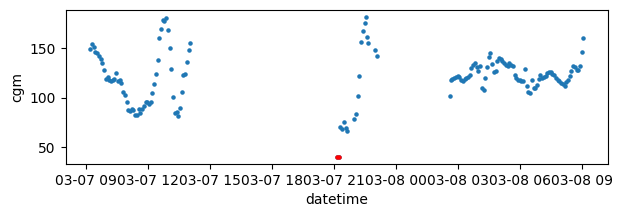

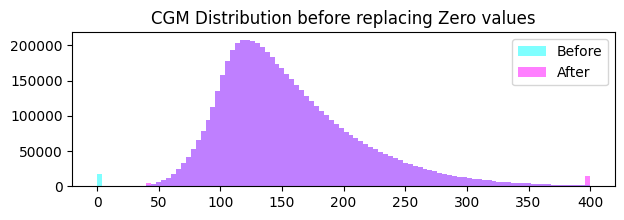

In [15]:
#draw cgm distribution
from src import cdf
#describe
temp = df_cgm.CGMValue[df_cgm.CGMValue.isin([0,400])].value_counts()/len(df_cgm)*100
temp.name = 'Percentage of CGM values'
display(temp)

# replace Zero CGMs with lower upper bounds
df_cgm['cgm'] = df_cgm['CGMValue']
i_zero = df_cgm.CGMValue == 0
df_cgm.loc[i_zero, 'cgm'] = df_cgm.HighLowIndicator.loc[i_zero].replace({ 2: 40, 1: 400 })

# draw an example
(patient_id,zero_datetime) = df_cgm.loc[(df_cgm.CGMValue==0),['PtID','datetime']].sample().iloc[0]
surrounding_cgms = df_cgm.loc[(df_cgm.PtID==patient_id) & 
                              df_cgm.datetime.between(zero_datetime-timedelta(hours=12), 
                                                      zero_datetime+timedelta(hours=12))].copy()

plt.figure(figsize=(7, 2)); ax = plt.gca()
surrounding_cgms.plot.scatter('datetime', 'cgm',ax=ax, marker='.')
surrounding_cgms.loc[surrounding_cgms.CGMValue==0].plot.scatter('datetime', 'cgm',color='red',ax=ax, marker='.');


#histogram
plt.figure(figsize=(7, 2))
plt.hist(df_cgm.CGMValue, bins=100, range=(0,400), alpha=0.5,label='Before',color='cyan')
plt.hist(df_cgm.cgm, bins=100, range=(0,400), alpha=0.5,label='After', color='magenta')
plt.legend()
plt.title("CGM Distribution before replacing Zero values");


## Datetimes are local and aligned
We want to make sure that datetimes of all datasets are in local time.

The DCLP3 data glossary makes no mention of UTC, timezone or zone. All datetime variables are described as local times. We want to verify by checking the distribution of mean CGM, basal rates and bolus doses to verify we see postprandial peaks in the morning, afternoon and evening as well as more stable glucose during the night.

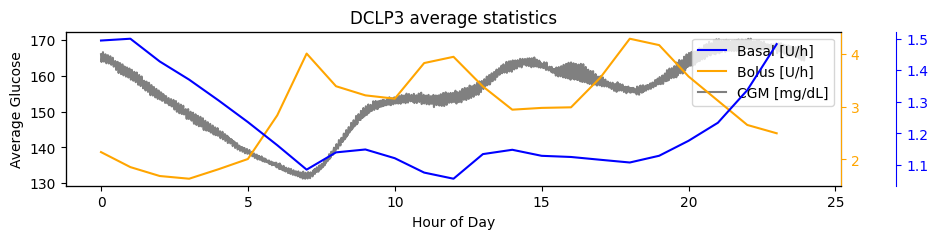

In [16]:
plt.figure(figsize=(10, 2)); ax=plt.gca()
df_cgm['date'] = df_cgm.datetime.dt.date
df_cgm['hour_of_day'] = df_cgm.datetime.dt.hour+df_cgm.datetime.dt.minute/60
agg = df_cgm.groupby(['PtID','hour_of_day']).CGMValue.mean()
agg.unstack().mean().plot(title='DCLP3 average statistics', xlabel='Hour of Day', ylabel='Average Glucose', ax=ax, color='gray')

#bolus
twin_ax = ax.twinx()
df_bolus['date'] = df_bolus.datetime.dt.date
df_bolus['hour_of_day'] = df_bolus.datetime.dt.hour
agg = df_bolus.groupby(['PtID','date','hour_of_day']).BolusAmount.sum()
agg.unstack().mean().plot(ax=twin_ax,color='orange')
#twin_ax.set_ylabel('Units',color='orange')
twin_ax.spines['right'].set_color('orange')
twin_ax.tick_params(axis='y', colors='orange')

#basal
twin_ax2 = ax.twinx()
df_basal['date'] = df_basal.datetime.dt.date
df_basal['hour_of_day'] = df_basal.datetime.dt.hour
agg = df_basal.groupby(['PtID','date','hour_of_day']).CommandedBasalRate.mean()
agg.unstack().mean().plot(ax=twin_ax2,color='blue')
#twin_ax2.set_ylabel('U/h', color='blue')
twin_ax2.spines['right'].set_position(('outward', 40))
twin_ax2.spines['right'].set_color('blue')
twin_ax2.tick_params(axis='y', colors='blue')

# Add color legend for the three plots
ax.plot([], [], color='blue', label='Basal [U/h]')
ax.plot([], [], color='orange', label='Bolus [U/h]')
ax.plot([], [], color='gray', label='CGM [mg/dL]')
ax.legend(loc='upper right')


We see bolus peaks at around 7 oClock, noon and evening. Slightly delayed we see postprandial glucose peaks as expected. Bassal rates follow normal rhythm with the exception that due to Control IQ basal rates slowly degreade over night, to lower glucose after dinner as part of the closed loop control. From this we can safely assume that all datetimes are in local time. 

## Boluses

### Bolus Duplicates
There are no bolus duplicates when including the BolusType column. The duplicates in boluses seem to be a result of Standard and Extended Bolus portions being reported at the same time. Is this true for all exteded boluses? Let's check.

In [17]:
print(f"Value Counts All Boluses: {df_bolus.BolusType.value_counts()}\n")
duplicated = df_bolus.loc[df_bolus.duplicated(['PtID', 'datetime'], keep=False)].sort_values(['PtID', 'datetime'])
print(f"Value Counts Duplicated Boluses: {duplicated.BolusType.value_counts()}")

Value Counts All Boluses: BolusType
Standard    203689
Extended      3993
Name: count, dtype: int64

Value Counts Duplicated Boluses: BolusType
Standard    45
Extended    45
Name: count, dtype: int64


### Extended Boluses

There are 4257 extended boluses (~1.9% of the boluses). We do not have any data on how the boluses were extended. After contacting JAEB, we did not receive further details. Users can set a % of the bolus to be delivered immediately and the remaining % will be delivered over a period of time the user sets. The default extended bolus is 50% up front and 50% over 2 hours.

From **JAEB** we know that the `Extended Bolus Duration` variable, present in PEDAP is not shared by Tandem for the DCLP3/5 datasets. Therefoe we need to make an assumption about the duration. We could use PEDAP to estimate the distribution and either sample from it or take the mean value. 

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_49196/2088633393.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  periods = df_bolus.groupby('PtID').apply(lambda x: find_periods.find_periods(x,'BolusType','datetime',


,index_start,index_end,time_start,time_end,PtID
0,4732,219854,2018-01-13 15:25:55,2018-01-13 15:41:18,3
1,191836,219855,2018-01-13 20:47:10,2018-01-13 21:48:40,3
2,13779,219856,2018-01-14 17:38:03,2018-01-14 17:43:24,3
3,88377,219857,2018-01-15 13:08:09,2018-01-15 13:08:09,3
4,149841,219858,2018-01-15 13:18:05,2018-01-15 15:14:13,3
...,...,...,...,...,...
3964,59571,219677,2018-09-21 19:47:09,2018-09-21 20:47:09,171
3965,60230,219678,2018-09-24 15:35:13,2018-09-24 16:35:13,171
3966,63087,219679,2018-09-24 18:31:22,2018-09-24 19:19:45,171
3967,91864,219680,2018-09-30 11:52:24,2018-09-30 12:52:24,171


,index_start,index_end,time_start,time_end,PtID
831,145065,220149,2018-01-17 21:45:00,2018-01-17 22:10:00,32
2036,172067,217330,2018-03-30 20:12:22,2018-03-30 20:42:21,118


,PtID,RecID,BolusAmount,BolusType,datetime,date,hour_of_day
145065,32,54980,0.588,Standard,2018-01-17 21:45:00,2018-01-17,21
220149,32,1212,2.352,Extended,2018-01-17 22:10:00,2018-01-17,22


,PtID,RecID,BolusAmount,BolusType,datetime,date,hour_of_day
172067,118,132037,0.395,Standard,2018-03-30 20:12:22,2018-03-30,20
217330,118,2614,1.185,Extended,2018-03-30 20:42:21,2018-03-30,20


We found 3969 periods for 3993 extended boluses
Mean (STD) [MEDIAN] of extended boluses: 59.02 (46.28), [55.42] minutes


(0.0, 500.0)

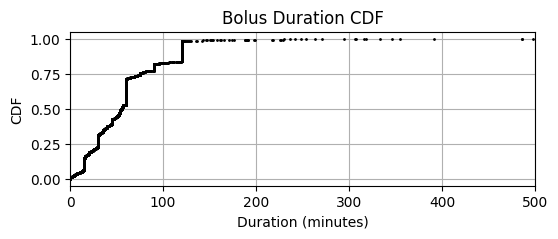

In [18]:
from src import find_periods
from importlib import reload
reload(find_periods)
periods = df_bolus.groupby('PtID').apply(lambda x: find_periods.find_periods(x,'BolusType','datetime',
                          lambda x: x =='Standard', 
                          lambda x: x=='Extended', use_last_start_occurence=True))
#drop rows with empty periods
periods = periods[periods.apply(lambda x: len(x)>0)]

#convert to dataframe, with one row per period
periods = pd.DataFrame(periods.explode(),columns=['Periods'])
PtIDs= periods.index
periods = pd.DataFrame(periods.Periods.tolist(), columns=find_periods.Period._fields)
periods['PtID'] = PtIDs

display(periods)

#show a sample
sample = periods.sample(2)
display(sample)
for index, row in sample.iterrows():
    display(df_bolus.loc[[row.index_start, row.index_end]])

print(f"We found {len(periods)} periods for {(df_bolus.BolusType=='Extended').sum()} extended boluses")

#plot CDF
durations = (periods.time_end-periods.time_start).dt.total_seconds()/60
print(f"Mean (STD) [MEDIAN] of extended boluses: {durations.mean():.2f} ({durations.std():.2f}), [{durations.median():.2f}] minutes")
plt.figure(figsize=(6,2)); ax = plt.gca()
cdf.plot_cdf(durations, title='Bolus Duration CDF', xlabel='Duration (minutes)', ylabel='CDF', linewidth=0, ax = ax)
plt.xlim(0,500)

In comparison **PEDAP**: 
Mean (STD) of extended boluses: 83.80 (45.53) minutes

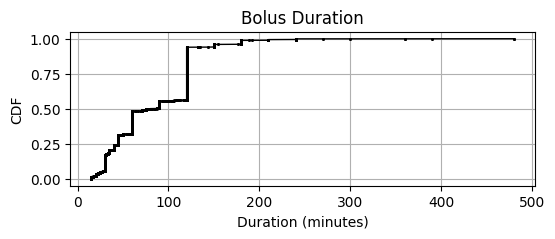

In [19]:
# Durations >8h
extremes = periods.loc[durations > 8*60]
print(f"We found {len(extremes)} periods >8h")
#examples = extremes.sample(2)
#display(examples)

#for index,row in examples.iterrows():
#    display(df_bolus.loc[[row.index_start,row.index_end]])

We found 7 periods >8h


As we can see we won't be able to clearly separate dual wave boluses (standard followed by an extended part) from *orphan* extended boluses (without standard part): Orphan Extended boluses will be incorretly matched to the previus standard bolus.However, this will happen only to a small percentage (In PEDAP only ~2% (170 out of 6460)) extended boluses did not have a standard bolus part. The T-Slim X2 allows durations >=8 hours, therefore pairs matched with durations >8 hours are definitely wrong.

Moving forward, we will 
1. assume that extended boluses are reported upon completion (as in PEDAP)
2. Estimate delivery_duration: 
  - Standard boluses: set to 0
  - Extended boluses: time difference to their matched standard boluses
  - Durations >8h (those are definitely matched incorrectly) will be set to 55 minutes (median value) 

In [20]:
#setting the durations
periods['Duration'] = periods.time_end - periods.time_start
periods.loc[periods.Duration>timedelta(hours=8), 'Duration'] = timedelta(minutes=55)

df_bolus['Duration'] = 0
df_bolus.loc[periods.index_end, 'datetime'] = (periods.time_end - periods.Duration).values
df_bolus.loc[periods.index_end, 'Duration'] = (periods.Duration.dt.total_seconds()/60).values
df_bolus.loc[periods.index_end]

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_49196/1256055155.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[15.38333333 61.5         5.35       ... 48.38333333 60.
 59.98333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_bolus.loc[periods.index_end, 'Duration'] = (periods.Duration.dt.total_seconds()/60).values


,PtID,RecID,BolusAmount,BolusType,datetime,date,hour_of_day,Duration
219854,3,37,1.330000,Extended,2018-01-13 15:25:55,2018-01-13,15,15.383333
219855,3,38,1.157544,Extended,2018-01-13 20:47:10,2018-01-13,21,61.500000
219856,3,39,0.150954,Extended,2018-01-14 17:38:03,2018-01-14,17,5.350000
219857,3,40,0.000000,Extended,2018-01-15 13:08:09,2018-01-15,13,0.000000
219858,3,41,1.665000,Extended,2018-01-15 13:18:05,2018-01-15,15,116.133333
...,...,...,...,...,...,...,...,...
219677,171,4274,9.000000,Extended,2018-09-21 19:47:09,2018-09-21,20,60.000000
219678,171,4275,6.000000,Extended,2018-09-24 15:35:13,2018-09-24,16,60.000000
219679,171,4276,5.590469,Extended,2018-09-24 18:31:22,2018-09-24,19,48.383333
219680,171,4294,4.713500,Extended,2018-09-30 11:52:24,2018-09-30,12,60.000000


In [24]:
display(df_bolus.Duration.loc[df_bolus.Duration>0].describe())
display(periods.Duration.describe())


count    3944.000000
mean       58.401513
std        39.496135
min         0.016667
25%        30.000000
50%        55.525000
75%        75.000000
max       391.566667
Name: Duration, dtype: float64

count                         3969
mean     0 days 00:58:02.019148400
std      0 days 00:39:38.506283205
min                0 days 00:00:00
25%                0 days 00:29:59
50%                0 days 00:55:12
75%                0 days 01:15:00
max                0 days 06:31:34
Name: Duration, dtype: object

## Basals

In PEDAP, we confirmed that basal rate change evnts are reported whenever basal delivery changes, not only if the new basal rate deviates from standard basal rate. Here, we apply the same logic and assume all basal rate changes are present.

## Class

In [44]:
from src.find_periods import find_periods, Period
from src import date_helper
from src import pandas_helper
from studies.studydataset import StudyDataset
import os
import sys
import pandas as pd
from functools import reduce

filepath = os.getcwd()
print(filepath)
sys.path.append(os.path.join(filepath, '..'))


class DCLP3(StudyDataset):
    def load_data(self):
        data_table_path = os.path.join(self.study_path, 'Data Files')
        df_bolus = pd.read_csv(os.path.join(data_table_path, 'Pump_BolusDelivered.txt'), sep='|', low_memory=False,
                               usecols=['RecID', 'PtID', 'DataDtTm', 'BolusAmount', 'BolusType', 'DataDtTm_adjusted'])

        df_basal = pd.read_csv(os.path.join(data_table_path, 'Pump_BasalRateChange.txt'), sep='|', low_memory=False,
                               usecols=['RecID', 'PtID', 'DataDtTm', 'CommandedBasalRate', 'DataDtTm_adjusted'])

        df_cgm = pd.read_csv(os.path.join(data_table_path, 'Pump_CGMGlucoseValue.txt'), sep='|', low_memory=False, 
                               usecols=['RecID', 'PtID', 'DataDtTm', 'CGMValue', 'DataDtTm_adjusted', 'HighLowIndicator'])

        
        # Handle duplicates
        # for cgm we just keep the first value
        df_cgm.drop_duplicates(['PtID', 'DataDtTm'], keep='first', inplace=True)
        # for basal we decided top use the maximum value
        _, _, drop_indexes = pandas_helper.get_duplicated_max_indexes(df_basal, ['PtID', 'DataDtTm'], 'CommandedBasalRate')
        df_basal.drop(drop_indexes, inplace=True)

        #remove patients with incomplete data
        intersecting_ids = reduce(np.intersect1d, (df_basal.PtID.unique(), df_bolus.PtID.unique(), df_cgm.PtID.unique()))
        df_basal = df_basal[df_basal.PtID.isin(intersecting_ids)]
        df_bolus = df_bolus[df_bolus.PtID.isin(intersecting_ids)]
        df_cgm = df_cgm[df_cgm.PtID.isin(intersecting_ids)]

        #setting datetimes (using the adjusted datetime if available)
        df_bolus['DataDtTm'] = pd.to_datetime(df_bolus['DataDtTm'])
        df_basal['DataDtTm'] = pd.to_datetime(df_basal['DataDtTm'])
        df_cgm['DataDtTm'] = pd.to_datetime(df_cgm['DataDtTm'])

        df_bolus['DataDtTm_adjusted'] = df_bolus.DataDtTm_adjusted.fillna(pd.NaT)
        df_basal['DataDtTm_adjusted'] = df_basal.DataDtTm_adjusted.fillna(pd.NaT)
        df_cgm['DataDtTm_adjusted'] = df_cgm.DataDtTm_adjusted.fillna(pd.NaT)

        df_cgm['DataDtTm_adjusted'] = pd.to_datetime(df_cgm['DataDtTm_adjusted'])
        df_basal['DataDtTm_adjusted'] = pd.to_datetime(df_basal['DataDtTm_adjusted'])
        df_bolus['DataDtTm_adjusted'] = pd.to_datetime(df_bolus['DataDtTm_adjusted'])

        self.df_bolus = df_bolus
        self.df_basal = df_basal
        self.df_cgm = df_cgm
    
    def __init__(self, study_path):
        super().__init__(study_path, 'PEDAP')

    def _extract_basal_event_history(self):
        temp = self.df_basal.copy()

        #adjust datetimes
        temp['DataDtTm'] = temp.DataDtTm_adjusted.fillna(temp.DataDtTm)

        #force datatypes needed for vectorized operations and to pass the data set validaiton
        temp['DataDtTm'] = pd.to_datetime(temp.DataDtTm)
        temp['PtID'] = temp.PtID.astype(str)
        temp = temp[['PtID','DataDtTm','CommandedBasalRate']].rename(columns={'PtID': 'patient_id', 'DataDtTm': 'datetime', 'CommandedBasalRate': 'basal_rate'})
        return temp

    def _extract_bolus_event_history(self):
        temp = self.df_bolus.copy()
        #adjust datetimes
        temp['DataDtTm'] = temp.DataDtTm_adjusted.fillna(temp.DataDtTm)
        
        #Match standard and extended boluses (this will incorrectly match purely extended boluses to standard boluses)
        periods = temp.groupby('PtID').apply(lambda x: find_periods(x,'BolusType','DataDtTm', lambda x: x == 'Standard',  lambda x: x == 'Extended', use_last_start_occurence=True))
        periods = periods[periods.apply(lambda x: len(x)>0)] 
        periods = pd.DataFrame(periods.explode(),columns=['Periods'])
        pt_ids_copy = periods.index
        periods = pd.DataFrame(periods.Periods.tolist(), columns=Period._fields)
        periods['PtID'] = pt_ids_copy
        
        #calculate extended bolus delivery durations
        #durations above 8 hours are not possible, therefore treated as extended boluses (no standard part)
        #and assigned 55 minutes duration which is the observed meadian duration
        periods['delivery_duration'] = periods.time_end - periods.time_start
        periods.loc[periods.delivery_duration>timedelta(hours=8), 'delivery_duration'] = timedelta(minutes=55)
        temp['delivery_duration'] = timedelta(0)
        #use .values here, otherwise will try to assign by index
        temp.loc[periods.index_end, 'DataDtTm'] = (periods.time_end - periods.delivery_duration).values
        temp.loc[periods.index_end, 'delivery_duration'] = periods.delivery_duration.values
        
        #force datatypes needed for vectorized operations and to pass the data set validaiton
        temp['DataDtTm'] = pd.to_datetime(temp.DataDtTm)
        temp['PtID'] = temp.PtID.astype(str)
        temp['delivery_duration'] = pd.to_timedelta(temp.delivery_duration)

        temp = temp[['PtID','DataDtTm','BolusAmount','delivery_duration']].rename(columns={'PtID': 'patient_id', 'DataDtTm': 'datetime', 'BolusAmount': 'bolus'})
        return temp

    def _extract_cgm_history(self):
        df_cgm = self.df_cgm.copy()
        #adjust datetimes
        df_cgm['DataDtTm'] = df_cgm.DataDtTm_adjusted.fillna(df_cgm.DataDtTm)

        # replace 0 CGMs with lower upper bounds
        b_zero = df_cgm.CGMValue == 0
        df_cgm.loc[b_zero, 'CGMValue'] = df_cgm.HighLowIndicator.loc[b_zero].replace({ 2: 40, 1: 400 })
        
        #force datatypes to pass the data set validaiton
        df_cgm['PtID'] = df_cgm.PtID.astype(str)
        df_cgm['DataDtTm'] = pd.to_datetime(df_cgm.DataDtTm)

        #reduce, rename, return
        return df_cgm.rename(columns={'PtID': 'patient_id', 'DataDtTm': 'datetime', 'CGMValue': 'cgm'})

/Users/jan/git/nudgebg/egvinsulin/notebooks


In [51]:
study_path = os.path.join(os.getcwd(), '../data/raw/DCLP3 Public Dataset - Release 3 - 2022-08-04/')
dclp3 = DCLP3(study_path)
dclp3.load_data()
df_basal_copy = dclp3.df_basal.copy()
df_bolus_copy = dclp3.df_bolus.copy()
df_cgm_copy = dclp3.df_cgm.copy()

basal = dclp3.extract_basal_event_history()
bolus = dclp3.extract_bolus_event_history()
cgm = dclp3.extract_cgm_history()